# MPB ModeSolver

Now let's obtain the plot on the right (Figure from [3]) :

![alt text](http://www.simpetus.com/files/SOI_waveguide_bands.png)

In [23]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

Start by defining the geometry from last time :

In [24]:
# Parameters for the waveguide
w = 0.5  # Si width (um)
h = 0.25  # Si height (um)

# Materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

sc_y = 2  # supercell width (um)
sc_z = 2  # supercell height (um)
resolution = 32  # pixels/um
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

# define the 2d blocks for the strip and substrate
geometry = [mp.Block(size=mp.Vector3(mp.inf, mp.inf, 0.5 * (sc_z - h)),
                     center=mp.Vector3(z=0.25 * (sc_z + h)), material=SiO2),
            mp.Block(size=mp.Vector3(mp.inf, w, h), material=Si)]

### Defining the simulation

Now, instead of only initializing the geometry, we will load simulation parameters.

In [25]:
# The k (i.e. beta, i.e. propagation constant) points to look at, in
# units of 2*pi/um.  We'll look at num_k points from k_min to k_max.
num_k = 20
k_min = 0.1
k_max = 2.0
k_points = mp.interpolate(num_k, [mp.Vector3(k_min), mp.Vector3(k_max)])

# Increase this to see more modes.  (The guided ones are the ones below the
# light line, i.e. those with frequencies < kmag / 1.45, where kmag
# is the corresponding column in the output if you grep for "freqs:".)
num_bands = 4

In [26]:
# ModeSolver object
ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    # Add new things pertaining to simulation
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands,
    )

In [27]:
ms.run_yeven()

Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 64 x 64.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 2, 0)
     (0, 0, 2)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 0.5)
Geometric objects:
     block, center = (0,0,0.5625)
          size (1e+20,1e+20,0.875)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.5,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: yeven.
Initializing fields to random numbers...
22 k-points
  Vector3<0.1, 0.0, 0.0>
  Vector3<0.19047619047619047, 0.0, 0.0>
  Vector3<0.28095238095238095, 0.0, 0.0>
  Vector3<0.37142857142857144, 0.0, 0.0>
  Vector3<0.46190476190476193, 0.0, 0.0>

It solved, great! We can see from the text output lines like :

`solve_kpoint (0.1,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 28 iterations.
freqs:, 1, 0.1, 0, 0, 0.1, 0.0807582, 0.0855765, 0.3147, 0.394675
elapsed time for k point: 0.14001059532165527`

This contains our band information. Unfortunately, MPB only keeps in memory one at a time. So we only have access to the last one :

In [28]:
print(ms.current_k)
print(ms.freqs)

Vector3<2.0, 0.0, 0.0>
[0.8295450310948325, 0.9103062577492965, 1.0688684652309763, 1.1935367080839783]


So let's do it again, this time capturing the output :

In [29]:
%%capture --no-stderr output
ms.run_yeven()

In [30]:
output_text = output.stdout
output_text.split('\n')

['Initializing eigensolver data',
 'Computing 4 bands with 1e-07 tolerance',
 'Working in 3 dimensions.',
 'Grid size is 1 x 64 x 64.',
 'Solving for 4 bands at a time.',
 'Creating Maxwell data...',
 'Mesh size is 3.',
 'Lattice vectors:',
 '     (1, 0, 0)',
 '     (0, 2, 0)',
 '     (0, 0, 2)',
 'Cell volume = 4',
 'Reciprocal lattice vectors (/ 2 pi):',
 '     (1, -0, 0)',
 '     (-0, 0.5, -0)',
 '     (0, -0, 0.5)',
 'Geometric objects:',
 '     block, center = (0,0,0.5625)',
 '          size (1e+20,1e+20,0.875)',
 '          axes (1,0,0), (0,1,0), (0,0,1)',
 '     block, center = (0,0,0)',
 '          size (1e+20,0.5,0.25)',
 '          axes (1,0,0), (0,1,0), (0,0,1)',
 'Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)',
 'Initializing epsilon function...',
 'Solving for band polarization: yeven.',
 'Initializing fields to random numbers...',
 '22 k-points',
 '  Vector3<0.1, 0.0, 0.0>',
 '  Vector3<0.19047619047619047, 0.0, 0.0>',
 '  Vector3<0.280952380

### Analyzing the results

Let's parse every line that begins with 'freqs :' in the output.

Notice the lines all have the same syntax `'freqs:, 22, 2, 0, 0, 2, 0.846477, 0.874081, 1.04852, 1.16543',`

i.e. for all the lines that start by 'freqs:' contains all the information we need in the form `freqs:, k index, kx, ky, kz, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8 ...`. Python's `split` function and treating strings as arrays (slicing and indexing) is handy :

In [31]:
freqs = []
ks = []
line_header = "yevenfreqs:"
for ln in output_text.split('\n'):
    if ln.startswith(line_header):
        print(ln)
        line = ln.split(', ')
        print(line)
        ks.append([line[2], line[3], line[4]])
        freqs.append([line[-4], line[-3], line[-2], line[-1]])
        
freqs = np.array(freqs, dtype=np.float32)
ks = np.array(ks, dtype=np.float32)

yevenfreqs:, 1, 0.1, 0, 0, 0.1, 0.0847852, 0.291179, 0.403839, 0.407085
['yevenfreqs:', '1', '0.1', '0', '0', '0.1', '0.0847852', '0.291179', '0.403839', '0.407085']
yevenfreqs:, 2, 0.190476, 0, 0, 0.190476, 0.159915, 0.317955, 0.418141, 0.426259
['yevenfreqs:', '2', '0.190476', '0', '0', '0.190476', '0.159915', '0.317955', '0.418141', '0.426259']
yevenfreqs:, 3, 0.280952, 0, 0, 0.280952, 0.231982, 0.357522, 0.440361, 0.455816
['yevenfreqs:', '3', '0.280952', '0', '0', '0.280952', '0.231982', '0.357522', '0.440361', '0.455816']
yevenfreqs:, 4, 0.371429, 0, 0, 0.371429, 0.299602, 0.406093, 0.468475, 0.494206
['yevenfreqs:', '4', '0.371429', '0', '0', '0.371429', '0.299602', '0.406093', '0.468475', '0.494206']
yevenfreqs:, 5, 0.461905, 0, 0, 0.461905, 0.362091, 0.459485, 0.500421, 0.539508
['yevenfreqs:', '5', '0.461905', '0', '0', '0.461905', '0.362091', '0.459485', '0.500421', '0.539508']
yevenfreqs:, 6, 0.552381, 0, 0, 0.552381, 0.419482, 0.513348, 0.534817, 0.587804
['yevenfreqs:', '

In [32]:
print(freqs)
print(ks)

[[0.0847852 0.291179  0.403839  0.407085 ]
 [0.159915  0.317955  0.418141  0.426259 ]
 [0.231982  0.357522  0.440361  0.455816 ]
 [0.299602  0.406093  0.468475  0.494206 ]
 [0.362091  0.459485  0.500421  0.539508 ]
 [0.419482  0.513348  0.534817  0.587804 ]
 [0.471513  0.563139  0.572914  0.634162 ]
 [0.51684   0.604889  0.618171  0.679571 ]
 [0.554162  0.645338  0.663461  0.725472 ]
 [0.584303  0.681385  0.709982  0.772123 ]
 [0.609588  0.709094  0.761046  0.820823 ]
 [0.632025  0.73129   0.814949  0.871023 ]
 [0.652864  0.750697  0.869789  0.909374 ]
 [0.672832  0.768754  0.921237  0.932271 ]
 [0.692354  0.786205  0.944665  0.980045 ]
 [0.711688  0.803451  0.962472  1.02936  ]
 [0.730994  0.820714  0.979993  1.07238  ]
 [0.750372  0.838125  0.997525  1.10774  ]
 [0.769884  0.855757  1.01515   1.13595  ]
 [0.78957   0.873653  1.0329    1.15819  ]
 [0.809453  0.891833  1.05081   1.17666  ]
 [0.829545  0.910306  1.06887   1.19354  ]]
[[0.1      0.       0.      ]
 [0.190476 0.       0. 

We can now plot. Let's add the lightline too :

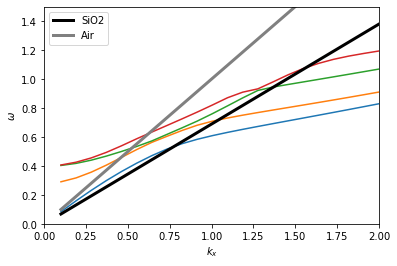

In [33]:
fig, ax = plt.subplots()

ax.plot(ks[:,0], freqs)
ax.plot(ks[:,0], ks[:,0]/1.45, 'k-', linewidth=3, label='SiO2')
ax.plot(ks[:,0], ks[:,0]/1, '-', color='gray', linewidth=3, label='Air')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$\omega$')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5])
ax.legend()